<a href="https://colab.research.google.com/github/sskunkworks/ai-notebook/blob/main/InceptionResNetV2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 데이터셋 준비

!unzip 'drive/MyDrive/datasets/ArtImage/test.zip'
!unzip 'drive/MyDrive/datasets/ArtImage/train.zip'
!unzip 'drive/MyDrive/datasets/ArtImage/test_labeled.zip'

In [2]:
import tensorflow as tf
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.models import load_model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionResNetV2
import numpy as np

In [ ]:
# 모델 셋업
baseModel = InceptionResNetV2(include_top=False, 
                                weights="imagenet",
                                #classes=7,
                                input_tensor = Input(shape=(224,224,3)))


headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(7, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
# 모델 학습을 freeze한다.
for layer in baseModel.layers:
  layer.trainable = False
model.compile(optimizer=Optimizer.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

In [4]:
#model.load_weights("drive/MyDrive/datasets/ArtImage/my_weights_99.h5")

In [5]:
# Image generator 설정
train_dir = '/content/train/'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        validation_split=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=1361,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(224, 224),
        batch_size=1361,
        class_mode='categorical',
        subset='validation') # set as validation data

Found 1361 images belonging to 7 classes.
Found 337 images belonging to 7 classes.


In [8]:
trained = model.fit(train_generator, validation_data=validation_generator, epochs=35)

Found 1361 images belonging to 7 classes.
Found 337 images belonging to 7 classes.
Epoch 1/35
22/22 [==============================] - 31s 1s/step - loss: 0.0633 - accuracy: 0.9816 - val_loss: 0.1893 - val_accuracy: 0.9436
Epoch 2/35
22/22 [==============================] - 28s 1s/step - loss: 0.0673 - accuracy: 0.9735 - val_loss: 0.1883 - val_accuracy: 0.9466
Epoch 3/35
22/22 [==============================] - 28s 1s/step - loss: 0.0584 - accuracy: 0.9809 - val_loss: 0.1934 - val_accuracy: 0.9466
Epoch 4/35
22/22 [==============================] - 28s 1s/step - loss: 0.0587 - accuracy: 0.9816 - val_loss: 0.1739 - val_accuracy: 0.9525
Epoch 5/35
22/22 [==============================] - 28s 1s/step - loss: 0.0655 - accuracy: 0.9787 - val_loss: 0.1649 - val_accuracy: 0.9614
Epoch 6/35
22/22 [==============================] - 28s 1s/step - loss: 0.0571 - accuracy: 0.9816 - val_loss: 0.1949 - val_accuracy: 0.9436
Epoch 7/35
22/22 [==============================] - 28s 1s/step - loss: 0.052

In [6]:
import matplotlib.pyplot as plt

def show_result():
  acc = trained.history['accuracy']
  val_acc = trained.history['val_accuracy']
  loss = trained.history['loss']
  val_loss = trained.history['val_loss']

  epochs = range(1,len(acc)+1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()



In [ ]:
show_result()

In [7]:
test_dir = '/content/test_labeled/'

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir, 
        target_size=(224, 224),
        batch_size=64,
        class_mode='categorical')



Found 350 images belonging to 7 classes.


In [25]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc', test_acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc 0.8742856979370117


In [16]:
model.save_weights("my_weights.h5")

In [8]:
# 일정 이상 학습 후, backbone을 미세조정한다.
baseModel.trainable = True

set_trainable = False
for layer in baseModel.layers:
  if layer.name == 'conv2d_200':
    set_trainable = True
  if set_trainable == True:
    layer.trainable = True
  else:
    layer.trainable = False

model.compile(optimizer=Optimizer.Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

trained = model.fit(train_generator, validation_data=validation_generator, epochs=35)

Epoch 1/35
1/1 [==============================] - 109s 109s/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.1966 - val_accuracy: 0.9585
Epoch 2/35
1/1 [==============================] - 24s 24s/step - loss: 0.0104 - accuracy: 0.9978 - val_loss: 0.1610 - val_accuracy: 0.9555
Epoch 3/35
1/1 [==============================] - 24s 24s/step - loss: 0.0098 - accuracy: 0.9978 - val_loss: 0.1960 - val_accuracy: 0.9407
Epoch 4/35
1/1 [==============================] - 24s 24s/step - loss: 0.0134 - accuracy: 0.9985 - val_loss: 0.1979 - val_accuracy: 0.9674
Epoch 5/35
1/1 [==============================] - 24s 24s/step - loss: 0.0086 - accuracy: 0.9993 - val_loss: 0.1421 - val_accuracy: 0.9614
Epoch 6/35
1/1 [==============================] - 24s 24s/step - loss: 0.0105 - accuracy: 0.9985 - val_loss: 0.1330 - val_accuracy: 0.9555
Epoch 7/35
1/1 [==============================] - 24s 24s/step - loss: 0.0073 - accuracy: 0.9993 - val_loss: 0.1536 - val_accuracy: 0.9585
Epoch 8/35
1/1 [=========

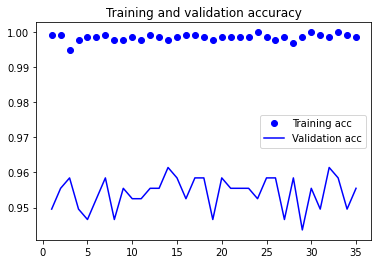

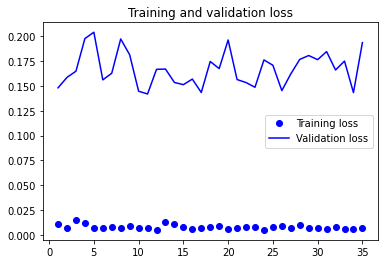

In [35]:
show_result()

In [10]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc', test_acc)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc 0.868571400642395


In [9]:
model.save_weights("my_weights.h5")